# Prosessing data


In [20]:
import os
import json
from PIL import Image
from tqdm import tqdm

def convert_cityscapes_to_yolo(cityscapes_path, output_path):
    # Define the classes we want to detect
    classes = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
    
    # Process each split (train, val, test)
    for split in ['train', 'val', 'test']:
        # Create output directory for labels
        split_output_path = os.path.join(output_path, split)
        os.makedirs(split_output_path, exist_ok=True)

        img_dir = os.path.join(cityscapes_path, 'leftImg8bit_trainvaltest', 'leftImg8bit', split)
        annotation_dir = os.path.join(cityscapes_path, 'gtFine_trainvaltest', 'gtFine', split)

        for city in tqdm(os.listdir(img_dir), desc=f"Processing {split}"):
            city_img_dir = os.path.join(img_dir, city)
            city_annotation_dir = os.path.join(annotation_dir, city)
            
            # Create output directory for the city
            city_output_path = os.path.join(split_output_path, city)
            os.makedirs(city_output_path, exist_ok=True)

            for filename in os.listdir(city_img_dir):
                if filename.endswith('_leftImg8bit.png'):
                    # Get image path
                    img_path = os.path.join(city_img_dir, filename)
                    
                    # Get corresponding annotation file
                    annotation_file = filename.replace('_leftImg8bit.png', '_gtFine_polygons.json')
                    annotation_path = os.path.join(city_annotation_dir, annotation_file)

                    # Read image dimensions
                    with Image.open(img_path) as img:
                        width, height = img.size

                    # Read annotation
                    with open(annotation_path, 'r') as f:
                        annotation = json.load(f)

                    # Create YOLO annotation file
                    yolo_annotation = []
                    for obj in annotation['objects']:
                        if obj['label'] in classes:
                            class_id = classes.index(obj['label'])
                            polygon = obj['polygon']
                            
                            # Convert polygon to bounding box
                            x_coords = [p[0] for p in polygon]
                            y_coords = [p[1] for p in polygon]
                            x_min, x_max = min(x_coords), max(x_coords)
                            y_min, y_max = min(y_coords), max(y_coords)

                            # Convert to YOLO format
                            x_center = (x_min + x_max) / (2 * width)
                            y_center = (y_min + y_max) / (2 * height)
                            box_width = (x_max - x_min) / width
                            box_height = (y_max - y_min) / height

                            yolo_annotation.append(f"{class_id} {x_center} {y_center} {box_width} {box_height}")

                    # Save YOLO annotation
                    yolo_filename = filename.replace('.png', '.txt')
                    with open(os.path.join(city_output_path, yolo_filename), 'w') as f:
                        f.write('\n'.join(yolo_annotation))

if __name__ == "__main__":
    cityscapes_path = '/teamspace/studios/this_studio/CityScapes_dataset'
    output_path = '/teamspace/studios/this_studio/dataset/labels'
    convert_cityscapes_to_yolo(cityscapes_path, output_path)


Processing test: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


# YOLOv5

In [3]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...



In [4]:
cd yolov5/

/teamspace/studios/this_studio/yolov5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [1]:
ls

CityScapes_dataset/       Datasetzips/    index.html*
Computer_Vision.ipynb*    Yolov5_Labels/  index.html.1*
Computer_Vision_2.ipynb*  cookies.txt*    yolov5/


In [2]:
cd yolov5/

/teamspace/studios/this_studio/yolov5


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [17]:
import os

def rename_label_files(dataset_path):
    labels_dir = os.path.join(dataset_path, 'labels')
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(labels_dir, split)
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            for filename in os.listdir(city_dir):
                if filename.endswith('.txt'):
                    new_filename = filename.replace('.txt', '_leftImg8bit.txt')
                    os.rename(os.path.join(city_dir, filename),
                              os.path.join(city_dir, new_filename))

dataset_path = '/teamspace/studios/this_studio/CityScapes_dataset_1'
rename_label_files(dataset_path)
print("Label files renamed successfully.")

Label files renamed successfully.


### YOLOv5 small

In [29]:
!python train.py --img 640 --batch 16 --epochs 100 --data data/cityscapes.yaml --weights yolov5s.pt --label-smoothing 0

train: weights=yolov5s.pt, cfg=, data=data/cityscapes.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_p

In [6]:
!python val.py --weights runs/train/exp12/weights/best.pt --data data/cityscapes.yaml --img 640 --batch 16

val: data=data/cityscapes.yaml, weights=['runs/train/exp12/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /teamspace/studios/this_studio/dataset/labels/val/frankfurt.cache.
val: WARNING ⚠️ /teamspace/studios/this_studio/dataset/images/val/frankfurt/frankfurt_000001_016273_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /teamspace/studios/this_studio/dataset/images/val/frankfurt/frankfurt_000001_017101_leftImg8bit.png: 1 duplicate labels removed
val: WARNING ⚠️ /teamspace/studios/this_studio/dataset/images/val/frankfurt/frankfurt_0

In [26]:
!python detect.py --weights runs/train/exp12/weights/best.pt --img 640 --conf 0.25 --source /teamspace/studios/this_studio/dataset/images/test/bielefeld/bielefeld_000000_001705_leftImg8bit.png

detect: weights=['runs/train/exp12/weights/best.pt'], source=/teamspace/studios/this_studio/dataset/images/test/bielefeld/bielefeld_000000_001705_leftImg8bit.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-330-gb20fa802 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /teamspace/studios/this_studio/dataset/images/test/bielefeld/bielefeld_000000_001705_leftImg8bit.png: 320x640 1 person, 15 cars, 60.5ms
Speed: 0.3ms pre-process, 60.5ms inference, 291.6ms NMS per image at shape (1, 3, 640, 640)
Results

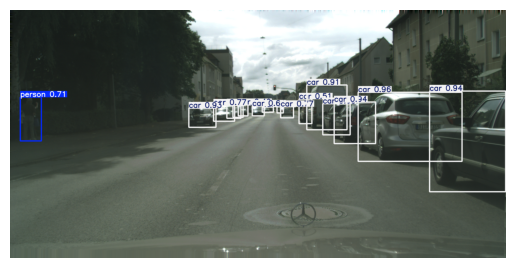

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image with detections
img_path = 'runs/detect/exp2/bielefeld_000000_001705_leftImg8bit.png'
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


## YOLOv5 Extra Larg

In [3]:
!python train.py --img 640 --batch 16 --epochs 100 --data data/cityscapes.yaml --weights yolov5x.pt --label-smoothing 0

train: weights=yolov5x.pt, cfg=, data=data/cityscapes.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), 1.88 KiB | 481.00 KiB/s, done.
From https://github.com/ultralytics/yolov5
   b20fa802..ab364

# SSD

In [13]:
import os
import json
import time
from PIL import Image
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.ssd import SSDHead
import torchvision.transforms as T
from torch.cuda.amp import GradScaler, autocast

from tqdm import tqdm

## Data Preparation

In [15]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.classes = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images_dir = os.path.join(root_dir, 'leftImg8bit_trainvaltest', 'leftImg8bit', split)
        self.annotations_dir = os.path.join(root_dir, 'gtFine_trainvaltest', 'gtFine', split)
        
        self.images = []
        self.annotations = []
        
        for city in os.listdir(self.images_dir):
            city_img_dir = os.path.join(self.images_dir, city)
            city_ann_dir = os.path.join(self.annotations_dir, city)
            
            for filename in os.listdir(city_img_dir):
                if filename.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_img_dir, filename)
                    annotation_path = os.path.join(city_ann_dir, filename.replace('_leftImg8bit.png', '_gtFine_polygons.json'))
                    
                    if os.path.exists(annotation_path):
                        self.images.append(image_path)
                        self.annotations.append(annotation_path)

    def __len__(self):
        return len(self.images)

    def polygon_to_bbox(self, polygon):
        x_coords, y_coords = zip(*polygon)
        return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

    def __getitem__(self, idx):
        img_path = self.images[idx]
        ann_path = self.annotations[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        with open(ann_path, 'r') as f:
            annotation = json.load(f)
        
        boxes = []
        labels = []
        
        for obj in annotation['objects']:
            if obj['label'] in self.classes:
                bbox = self.polygon_to_bbox(obj['polygon'])
                boxes.append(bbox)
                labels.append(self.class_to_idx[obj['label']])
        
        # Handle case where there are no objects of interest
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        if self.transform:
            image, target = self.apply_transform(image, target, self.transform)
        
        return image, target

    def apply_transform(self, image, target, transform):
        orig_w, orig_h = image.size
        image = transform(image)
        new_w, new_h = 640, 640
        w_scale, h_scale = new_w / orig_w, new_h / orig_h
        boxes = target['boxes']
        if boxes.shape[0] > 0:  # Only apply scaling if there are boxes
            scaled_boxes = boxes * torch.as_tensor([w_scale, h_scale, w_scale, h_scale])
            target['boxes'] = scaled_boxes
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(T.Resize((640, 640)))
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3))
    return T.Compose(transforms)

### Model Setup

In [16]:
def get_ssd_model(num_classes):
    model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
    in_channels = [512, 1024, 512, 256, 256, 256]
    num_anchors = [4, 6, 6, 6, 4, 4]
    model.head = SSDHead(in_channels, num_anchors, num_classes)
    return model

### Training 

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, scaler, use_mixed_precision):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader, desc="Training", leave=False):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        images = [img for img, target in zip(images, targets) if target['boxes'].numel() > 0]
        targets = [target for target in targets if target['boxes'].numel() > 0]
        
        if len(images) == 0:
            continue

        optimizer.zero_grad()
        
        if use_mixed_precision:
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
        
        total_loss += losses.item()
    
    return total_loss / len(data_loader)

### Validation

In [18]:
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validating", leave=False):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            images = [img for img, target in zip(images, targets) if target['boxes'].numel() > 0]
            targets = [target for target in targets if target['boxes'].numel() > 0]
            
            if len(images) == 0:
                continue

            model.train()
            loss_dict = model(images, targets)
            model.eval()

            if isinstance(loss_dict, list):
                continue

            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    
    return total_loss / len(data_loader)

In [19]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

root_dir = '/teamspace/studios/this_studio/Cityscapes_2'
num_classes = 9
num_epochs = 100
batch_size = 64
num_workers = 8
use_mixed_precision = True

train_dataset = CityscapesDataset(root_dir=root_dir, split='train', transform=get_transform(train=True))
val_dataset = CityscapesDataset(root_dir=root_dir, split='val', transform=get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

model = get_ssd_model(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

scaler = GradScaler()
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_start_time = time.time()

    train_loss = train_one_epoch(model, optimizer, train_loader, device, scaler, use_mixed_precision)
    val_loss = validate(model, val_loader, device)
    scheduler.step()

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time:.2f} seconds")

torch.save(model.state_dict(), 'ssd_cityscapes.pth')
print("Model saved as ssd_cityscapes.pth")

Using device: cuda
Number of training samples: 2975
Number of validation samples: 500

Epoch 1/100


Epoch 1 completed in 98.23 seconds
Train Loss: 44.7314, Validation Loss: 7.3319

Epoch 2/100


Epoch 2 completed in 84.16 seconds
Train Loss: 6.7460, Validation Loss: 6.6926

Epoch 3/100


Epoch 3 completed in 81.41 seconds
Train Loss: 6.4636, Validation Loss: 6.5837

Epoch 4/100


Epoch 4 completed in 80.02 seconds
Train Loss: 6.3240, Validation Loss: 6.4601

Epoch 5/100


Epoch 5 completed in 80.05 seconds
Train Loss: 6.2622, Validation Loss: 6.4335

Epoch 6/100


Epoch 6 completed in 80.48 seconds
Train Loss: 6.2348, Validation Loss: 6.4049

Epoch 7/100


Epoch 7 completed in 80.55 seconds
Train Loss: 6.2033, Validation Loss: 6.3619

Epoch 8/100


Epoch 8 completed in 80.56 seconds
Train Loss: 6.1881, Validation Loss: 6.3566

Epoch 9/100


Epoch 9 completed in 81.41 seconds
Train Loss: 6.1864, Validation Loss: 6.3503

Epoch 10/100


Epoch 10 completed in 84.68 seconds
Train Loss: 6.1849, Validation Loss: 6.3500

Epoch 11/100


Epoch 11 completed in 81.59 seconds
Train Loss: 6.1797, Validation Loss: 6.3512

Epoch 12/100


Epoch 12 completed in 81.03 seconds
Train Loss: 6.1833, Validation Loss: 6.3501

Epoch 13/100


Epoch 13 completed in 80.24 seconds
Train Loss: 6.1759, Validation Loss: 6.3493

Epoch 14/100


Epoch 14 completed in 80.25 seconds
Train Loss: 6.1767, Validation Loss: 6.3486

Epoch 15/100


Epoch 15 completed in 80.22 seconds
Train Loss: 6.1827, Validation Loss: 6.3499

Epoch 16/100


Epoch 16 completed in 79.92 seconds
Train Loss: 6.1871, Validation Loss: 6.3480

Epoch 17/100


Epoch 17 completed in 82.98 seconds
Train Loss: 6.1826, Validation Loss: 6.3483

Epoch 18/100


Epoch 18 completed in 82.41 seconds
Train Loss: 6.1743, Validation Loss: 6.3482

Epoch 19/100


Epoch 19 completed in 82.90 seconds
Train Loss: 6.1768, Validation Loss: 6.3494

Epoch 20/100


Epoch 20 completed in 83.86 seconds
Train Loss: 6.1761, Validation Loss: 6.3498

Epoch 21/100


Epoch 21 completed in 83.59 seconds
Train Loss: 6.1774, Validation Loss: 6.3473

Epoch 22/100


Epoch 22 completed in 83.05 seconds
Train Loss: 6.1779, Validation Loss: 6.3485

Epoch 23/100


Epoch 23 completed in 85.75 seconds
Train Loss: 6.1714, Validation Loss: 6.3490

Epoch 24/100


Epoch 24 completed in 84.51 seconds
Train Loss: 6.1773, Validation Loss: 6.3487

Epoch 25/100


Epoch 25 completed in 82.50 seconds
Train Loss: 6.1731, Validation Loss: 6.3500

Epoch 26/100


Epoch 26 completed in 82.95 seconds
Train Loss: 6.1828, Validation Loss: 6.3493

Epoch 27/100


Epoch 27 completed in 82.36 seconds
Train Loss: 6.1832, Validation Loss: 6.3497

Epoch 28/100


Epoch 28 completed in 82.37 seconds
Train Loss: 6.1765, Validation Loss: 6.3486

Epoch 29/100


Epoch 29 completed in 84.29 seconds
Train Loss: 6.1819, Validation Loss: 6.3484

Epoch 30/100


Epoch 30 completed in 84.36 seconds
Train Loss: 6.1692, Validation Loss: 6.3476

Epoch 31/100


Epoch 31 completed in 83.12 seconds
Train Loss: 6.1766, Validation Loss: 6.3498

Epoch 32/100


Epoch 32 completed in 82.90 seconds
Train Loss: 6.1729, Validation Loss: 6.3498

Epoch 33/100


Epoch 33 completed in 82.78 seconds
Train Loss: 6.1810, Validation Loss: 6.3495

Epoch 34/100


Epoch 34 completed in 81.22 seconds
Train Loss: 6.1780, Validation Loss: 6.3488

Epoch 35/100


Epoch 35 completed in 82.74 seconds
Train Loss: 6.1723, Validation Loss: 6.3492

Epoch 36/100


Epoch 36 completed in 82.05 seconds
Train Loss: 6.1720, Validation Loss: 6.3487

Epoch 37/100


Epoch 37 completed in 84.06 seconds
Train Loss: 6.1787, Validation Loss: 6.3484

Epoch 38/100


Epoch 38 completed in 82.36 seconds
Train Loss: 6.1780, Validation Loss: 6.3480

Epoch 39/100


Epoch 39 completed in 83.25 seconds
Train Loss: 6.1660, Validation Loss: 6.3483

Epoch 40/100


Epoch 40 completed in 81.95 seconds
Train Loss: 6.1745, Validation Loss: 6.3490

Epoch 41/100


Epoch 41 completed in 83.37 seconds
Train Loss: 6.1789, Validation Loss: 6.3487

Epoch 42/100


Epoch 42 completed in 81.67 seconds
Train Loss: 6.1804, Validation Loss: 6.3482

Epoch 43/100


Epoch 43 completed in 82.87 seconds
Train Loss: 6.1709, Validation Loss: 6.3502

Epoch 44/100


Epoch 44 completed in 82.35 seconds
Train Loss: 6.1768, Validation Loss: 6.3486

Epoch 45/100


Epoch 45 completed in 83.29 seconds
Train Loss: 6.1785, Validation Loss: 6.3487

Epoch 46/100


Epoch 46 completed in 82.92 seconds
Train Loss: 6.1739, Validation Loss: 6.3480

Epoch 47/100


Epoch 47 completed in 83.12 seconds
Train Loss: 6.1827, Validation Loss: 6.3483

Epoch 48/100


Epoch 48 completed in 82.32 seconds
Train Loss: 6.1807, Validation Loss: 6.3477

Epoch 49/100


Epoch 49 completed in 82.95 seconds
Train Loss: 6.1810, Validation Loss: 6.3498

Epoch 50/100


Epoch 50 completed in 82.48 seconds
Train Loss: 6.1860, Validation Loss: 6.3504

Epoch 51/100


Epoch 51 completed in 82.51 seconds
Train Loss: 6.1774, Validation Loss: 6.3499

Epoch 52/100


Epoch 52 completed in 82.96 seconds
Train Loss: 6.1839, Validation Loss: 6.3491

Epoch 53/100


Epoch 53 completed in 83.61 seconds
Train Loss: 6.1781, Validation Loss: 6.3476

Epoch 54/100


Epoch 54 completed in 84.45 seconds
Train Loss: 6.1797, Validation Loss: 6.3494

Epoch 55/100


Epoch 55 completed in 83.95 seconds
Train Loss: 6.1732, Validation Loss: 6.3485

Epoch 56/100


Epoch 56 completed in 83.46 seconds
Train Loss: 6.1794, Validation Loss: 6.3492

Epoch 57/100


Epoch 57 completed in 81.93 seconds
Train Loss: 6.1797, Validation Loss: 6.3502

Epoch 58/100


Epoch 58 completed in 81.55 seconds
Train Loss: 6.1778, Validation Loss: 6.3492

Epoch 59/100


Epoch 59 completed in 82.46 seconds
Train Loss: 6.1777, Validation Loss: 6.3487

Epoch 60/100


Epoch 60 completed in 81.26 seconds
Train Loss: 6.1744, Validation Loss: 6.3513

Epoch 61/100


Epoch 61 completed in 82.66 seconds
Train Loss: 6.1836, Validation Loss: 6.3487

Epoch 62/100


Epoch 62 completed in 82.99 seconds
Train Loss: 6.1818, Validation Loss: 6.3492

Epoch 63/100


Epoch 63 completed in 82.30 seconds
Train Loss: 6.1814, Validation Loss: 6.3491

Epoch 64/100


Epoch 64 completed in 81.74 seconds
Train Loss: 6.1846, Validation Loss: 6.3498

Epoch 65/100


Epoch 65 completed in 82.82 seconds
Train Loss: 6.1855, Validation Loss: 6.3505

Epoch 66/100


Epoch 66 completed in 81.44 seconds
Train Loss: 6.1794, Validation Loss: 6.3479

Epoch 67/100


Epoch 67 completed in 80.95 seconds
Train Loss: 6.1732, Validation Loss: 6.3488

Epoch 68/100


Epoch 68 completed in 82.90 seconds
Train Loss: 6.1771, Validation Loss: 6.3490

Epoch 69/100


Epoch 69 completed in 82.23 seconds
Train Loss: 6.1859, Validation Loss: 6.3496

Epoch 70/100


Epoch 70 completed in 81.94 seconds
Train Loss: 6.1869, Validation Loss: 6.3493

Epoch 71/100


Epoch 71 completed in 83.21 seconds
Train Loss: 6.1737, Validation Loss: 6.3474

Epoch 72/100


Epoch 72 completed in 82.20 seconds
Train Loss: 6.1875, Validation Loss: 6.3504

Epoch 73/100


Epoch 73 completed in 81.34 seconds
Train Loss: 6.1771, Validation Loss: 6.3494

Epoch 74/100


Epoch 74 completed in 83.76 seconds
Train Loss: 6.1774, Validation Loss: 6.3501

Epoch 75/100


Epoch 75 completed in 82.57 seconds
Train Loss: 6.1773, Validation Loss: 6.3490

Epoch 76/100


Epoch 76 completed in 82.61 seconds
Train Loss: 6.1733, Validation Loss: 6.3493

Epoch 77/100


Epoch 77 completed in 82.05 seconds
Train Loss: 6.1796, Validation Loss: 6.3481

Epoch 78/100


Epoch 78 completed in 83.11 seconds
Train Loss: 6.1780, Validation Loss: 6.3494

Epoch 79/100


Epoch 79 completed in 84.10 seconds
Train Loss: 6.1875, Validation Loss: 6.3496

Epoch 80/100


Epoch 80 completed in 84.31 seconds
Train Loss: 6.1790, Validation Loss: 6.3484

Epoch 81/100


Epoch 81 completed in 83.78 seconds
Train Loss: 6.1788, Validation Loss: 6.3483

Epoch 82/100


Epoch 82 completed in 82.37 seconds
Train Loss: 6.1821, Validation Loss: 6.3487

Epoch 83/100


Epoch 83 completed in 83.48 seconds
Train Loss: 6.1825, Validation Loss: 6.3490

Epoch 84/100


Epoch 84 completed in 82.33 seconds
Train Loss: 6.1897, Validation Loss: 6.3502

Epoch 85/100


Epoch 85 completed in 82.27 seconds
Train Loss: 6.1881, Validation Loss: 6.3479

Epoch 86/100


Epoch 86 completed in 83.77 seconds
Train Loss: 6.1827, Validation Loss: 6.3503

Epoch 87/100


Epoch 87 completed in 84.06 seconds
Train Loss: 6.1841, Validation Loss: 6.3509

Epoch 88/100


Epoch 88 completed in 82.30 seconds
Train Loss: 6.1738, Validation Loss: 6.3477

Epoch 89/100


Epoch 89 completed in 84.10 seconds
Train Loss: 6.1847, Validation Loss: 6.3478

Epoch 90/100


Epoch 90 completed in 83.25 seconds
Train Loss: 6.1785, Validation Loss: 6.3495

Epoch 91/100


Epoch 91 completed in 83.46 seconds
Train Loss: 6.1818, Validation Loss: 6.3476

Epoch 92/100


Epoch 92 completed in 83.55 seconds
Train Loss: 6.1763, Validation Loss: 6.3483

Epoch 93/100


Epoch 93 completed in 82.52 seconds
Train Loss: 6.1844, Validation Loss: 6.3490

Epoch 94/100


Epoch 94 completed in 81.47 seconds
Train Loss: 6.1802, Validation Loss: 6.3475

Epoch 95/100


Epoch 95 completed in 84.78 seconds
Train Loss: 6.1861, Validation Loss: 6.3483

Epoch 96/100


Epoch 96 completed in 83.63 seconds
Train Loss: 6.1694, Validation Loss: 6.3492

Epoch 97/100


Epoch 97 completed in 81.87 seconds
Train Loss: 6.1746, Validation Loss: 6.3479

Epoch 98/100


Epoch 98 completed in 82.14 seconds
Train Loss: 6.1802, Validation Loss: 6.3476

Epoch 99/100


Epoch 99 completed in 83.37 seconds
Train Loss: 6.1857, Validation Loss: 6.3484

Epoch 100/100


Epoch 100 completed in 83.37 seconds
Train Loss: 6.1748, Validation Loss: 6.3488

Training completed in 8277.67 seconds
Model saved as ssd_cityscapes.pth


## evaluation 

In [32]:
model_path = 'ssd_cityscapes.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [44]:
from torchvision.ops import box_iou
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [58]:
def compute_metrics(model, data_loader, device, iou_threshold=0.3, nms_threshold=0.5, confidence_threshold=0.001):
    model.eval()
    all_preds = []
    all_targets = []
    class_counts = {i: 0 for i in range(9)}  # Assuming 9 classes including background
    total_gt = {i: 0 for i in range(9)}  # Ground truth counts
    
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                boxes = output['boxes']
                scores = output['scores']
                labels = output['labels']
                
                # Filter out low confidence predictions
                keep = scores > confidence_threshold
                boxes = boxes[keep]
                scores = scores[keep]
                labels = labels[keep]
                
                # Apply NMS
                keep = torchvision.ops.nms(boxes, scores, iou_threshold=nms_threshold)
                boxes = boxes[keep]
                scores = scores[keep]
                labels = labels[keep]
                
                target_boxes = target['boxes']
                target_labels = target['labels']
                
                # Count ground truths
                for t in target_labels:
                    total_gt[t.item()] += 1
                
                if len(boxes) > 0 and len(target_boxes) > 0:
                    iou = box_iou(boxes, target_boxes)
                    max_iou, max_idx = iou.max(dim=1)
                    
                    for pred_label, iou_val, target_idx in zip(labels, max_iou, max_idx):
                        if iou_val > iou_threshold:
                            all_preds.append(pred_label.item())
                            all_targets.append(target_labels[target_idx].item())
                        else:
                            all_preds.append(0)  # 0 for background
                            all_targets.append(target_labels[target_idx].item())
                        class_counts[pred_label.item()] += 1
                
                # Add unmatched ground truths as false negatives
                for target_label in target_labels:
                    if target_label.item() not in all_targets[-len(target_labels):]:
                        all_preds.append(0)  # 0 for background
                        all_targets.append(target_label.item())
    
    print("Predictions per class:")
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} predictions, {total_gt[class_id]} ground truths")
    
    return all_preds, all_targets

    
def print_metrics(all_preds, all_targets, class_names):
    cm = confusion_matrix(all_targets, all_preds)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nPer-class metrics:")
    for i, class_name in enumerate(class_names):
        if i < cm.shape[0]:
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"{class_name:>12}: Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        else:
            print(f"{class_name:>12}: No data in confusion matrix")
    
    # Overall metrics
    accuracy = np.diag(cm).sum() / cm.sum()
    print(f"\nOverall Accuracy: {accuracy:.3f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:cm.shape[0]], yticklabels=class_names[:cm.shape[0]])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix saved as 'confusion_matrix.png'")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating: 100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


Predictions per class:
Class 0: 0 predictions, 3419 ground truths
Class 1: 0 predictions, 556 ground truths
Class 2: 69961 predictions, 4667 ground truths
Class 3: 235 predictions, 93 ground truths
Class 4: 2173 predictions, 98 ground truths
Class 5: 12793 predictions, 23 ground truths
Class 6: 0 predictions, 149 ground truths
Class 7: 12903 predictions, 1175 ground truths
Class 8: 0 predictions, 0 ground truths

Confusion Matrix:
[[20984     0  1017     6     5     7     0    94]
 [ 2854     0   259     0     0     0     0     3]
 [52013     0  5159    29    51   594     0   450]
 [ 2679     0   139     1    13    28     0     2]
 [ 2540     0   168     3    21    42     0     2]
 [ 1254     0    33     1     5    19     0     0]
 [ 1101     0   135     0     0     4     0     6]
 [ 6097     0   717     1     0    26     0   119]]

Per-class metrics:
  background: Precision: 0.234, Recall: 0.949, F1: 0.376
      person: Precision: 0.000, Recall: 0.000, F1: 0.000
       rider: Precisio

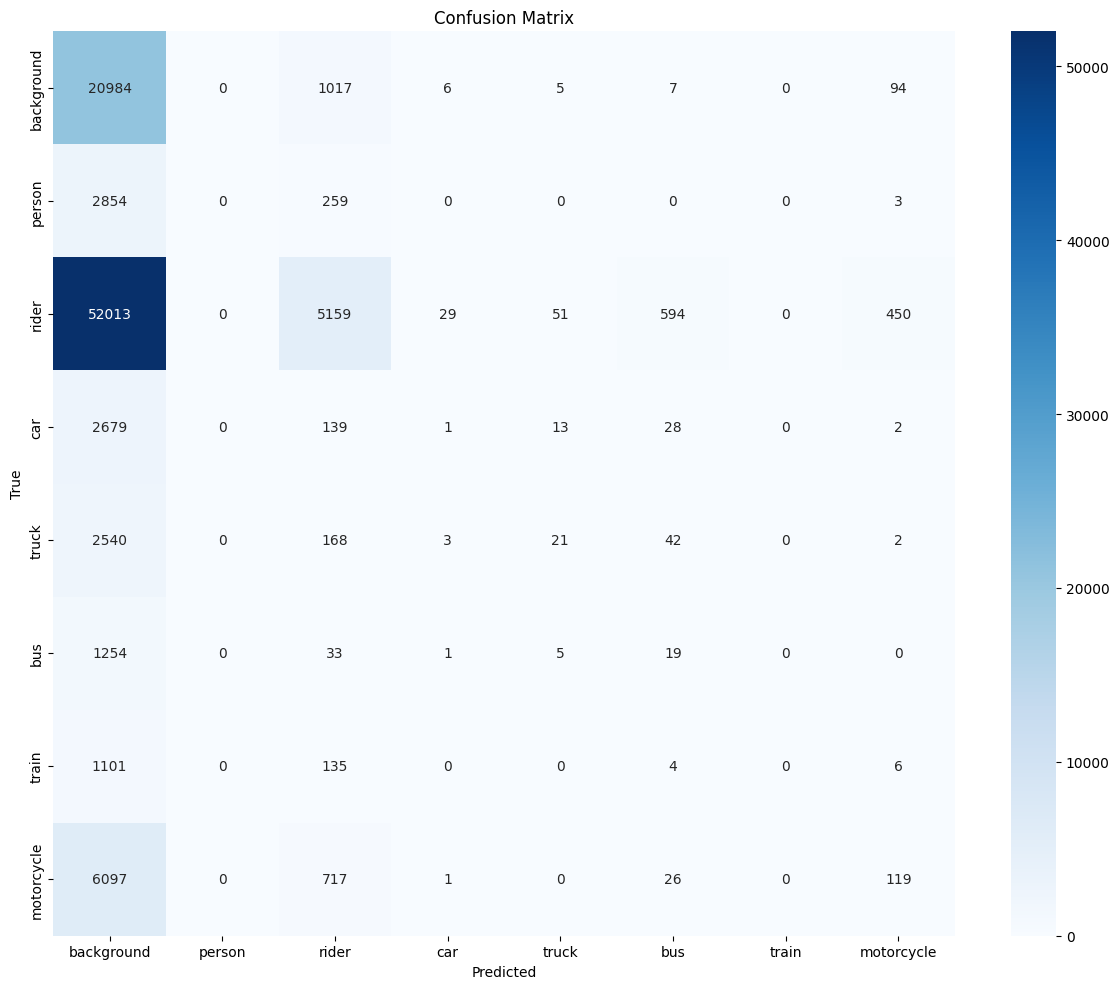

In [59]:
# Load the saved model
model = get_ssd_model(num_classes)
model.load_state_dict(torch.load('ssd_cityscapes.pth'))
model.to(device)

# Compute metrics 
all_preds, all_targets = compute_metrics(model, val_loader, device, iou_threshold=0.3, nms_threshold=0.6, confidence_threshold=0.05)
# Print metrics and confusion matrix
class_names = ['background', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
print_metrics(all_preds, all_targets, class_names)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel summary: {len(list(model.modules()))} layers, {total_params} parameters, {trainable_params} trainable parameters")